In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Data Acquisition

### Primary Source:
**MovieLens 1M Dataset**

- `ratings.dat`: `user_id`, `movie_id`, `rating`, `timestamp`  
- `movies.dat`: `movie_id`, `title`, `genres`  
- `users.dat`: `user_id`, `age`, `gender`, `occupation`, `zip_code`

### Enrichment:
- Extract **movie descriptions** (e.g., from [TMDb](https://www.themoviedb.org/))
- Derive **session/time-of-day buckets** from `timestamp` field (e.g., morning, afternoon, evening)

In [3]:
# Load ratings.dat
ratings = pd.read_csv(
    './data/ratings.dat',
    sep='::',
    engine='python',
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# Load movies.dat
movies = pd.read_csv(
    './data/movies.dat',
    sep='::',
    engine='python',
    names=['movie_id', 'title', 'genres'],
    encoding='latin-1'
)

# Load users.dat
users = pd.read_csv(
    './data/users.dat',
    sep='::',
    engine='python',
    names=['userID', 'gender', 'age', 'occupation', 'zip-code'],
    encoding='latin-1'
)

#### Movies

In [4]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


#### Ratings


In [6]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
ratings.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [8]:
ratings.describe()

,user_id,movie_id,rating,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


#### Users


In [47]:
users.head()

,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [9]:
users.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userID      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [10]:
users.describe()

,userID,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


## Preprocessing Steps

- Convert `timestamp` to `datetime`, and extract:
  - `hour`, `dayofweek`, and `time_bucket` (e.g., morning, afternoon)
  
- One-hot encode **genres** (multi-label)

- Clean or standardize **movie titles** (e.g., remove year, trim whitespace)

- Filter out **users and movies** with very few interactions (e.g., fewer than 10 ratings)

- Normalize ratings if needed (e.g., **mean-centering** for matrix factorization)

In [11]:
users.head()

,userID,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [12]:
# Check for duplicates in ratings
print("Duplicate rows in ratings:", ratings.duplicated().sum())

# Check for duplicates in movies
print("Duplicate rows in movies:", movies.duplicated().sum())

# Check for duplicates in users
print("Duplicate rows in users:", users.duplicated().sum())

Duplicate rows in ratings: 0
Duplicate rows in movies: 0
Duplicate rows in users: 0


In [13]:
#check repeated ratings for any (user, movie) pair
ratings.groupby(['user_id', 'movie_id']).size().max()

1

No user rated the same movie more than once in the dataset

In [14]:
# Define function to map hour to time_bucket
def get_time_bucket(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

In [15]:
# Convert UNIX timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Extract hour and day of week
ratings['hour'] = ratings['datetime'].dt.hour
ratings['dayofweek'] = ratings['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday

# Apply time bucket mapping
ratings['time_bucket'] = ratings['hour'].apply(get_time_bucket)

In [16]:
ratings.head()

,user_id,movie_id,rating,timestamp,datetime,hour,dayofweek,time_bucket
0,1,1193,5,978300760,2000-12-31 22:12:40,22,6,night
1,1,661,3,978302109,2000-12-31 22:35:09,22,6,night
2,1,914,3,978301968,2000-12-31 22:32:48,22,6,night
3,1,3408,4,978300275,2000-12-31 22:04:35,22,6,night
4,1,2355,5,978824291,2001-01-06 23:38:11,23,5,night


In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   user_id      1000209 non-null  int64         
 1   movie_id     1000209 non-null  int64         
 2   rating       1000209 non-null  int64         
 3   timestamp    1000209 non-null  int64         
 4   datetime     1000209 non-null  datetime64[ns]
 5   hour         1000209 non-null  int32         
 6   dayofweek    1000209 non-null  int32         
 7   time_bucket  1000209 non-null  object        
dtypes: datetime64[ns](1), int32(2), int64(4), object(1)
memory usage: 53.4+ MB


In [18]:
# Split genres by pipe 
genre_codes = movies['genres'].str.get_dummies(sep='|')

# Join the one-hot genre columns back to the movies DataFrame
movies = pd.concat([movies, genre_codes], axis=1)

In [19]:
# Extract year using regex 
movies['year'] = pd.to_numeric(movies['title'].str.extract(r'\((\d{4})\)')[0], errors='coerce').astype('Int64')

In [20]:
movies.head()

,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     3883 non-null   int64 
 1   title        3883 non-null   object
 2   genres       3883 non-null   object
 3   Action       3883 non-null   int64 
 4   Adventure    3883 non-null   int64 
 5   Animation    3883 non-null   int64 
 6   Children's   3883 non-null   int64 
 7   Comedy       3883 non-null   int64 
 8   Crime        3883 non-null   int64 
 9   Documentary  3883 non-null   int64 
 10  Drama        3883 non-null   int64 
 11  Fantasy      3883 non-null   int64 
 12  Film-Noir    3883 non-null   int64 
 13  Horror       3883 non-null   int64 
 14  Musical      3883 non-null   int64 
 15  Mystery      3883 non-null   int64 
 16  Romance      3883 non-null   int64 
 17  Sci-Fi       3883 non-null   int64 
 18  Thriller     3883 non-null   int64 
 19  War          3883 non-null 

In [22]:
movies.describe()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.0
mean,1986.049446,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512,1986.066959
std,1146.778349,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187,16.89569
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1919.0
25%,982.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1982.0
50%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.0
75%,2980.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.0
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2000.0


## Targeted EDA Questions

### User Behavior & Ratings Trends
- What is the distribution of ratings (1–5)? Is it skewed?
- What is the average rating per user? Are some users more lenient/harsh?
- Are users more likely to give certain ratings at certain times of day?
- How many users have rated fewer than 10 movies (i.e., cold-start users)?

In [23]:
ratings['rating'].value_counts(normalize=True).sort_index()

rating
1    0.056162
2    0.107535
3    0.261142
4    0.348898
5    0.226263
Name: proportion, dtype: float64

#### Ratings of 4 and 5 make up over 57% of all ratings - right-skewed, meaning users are more likely to give higher ratings.

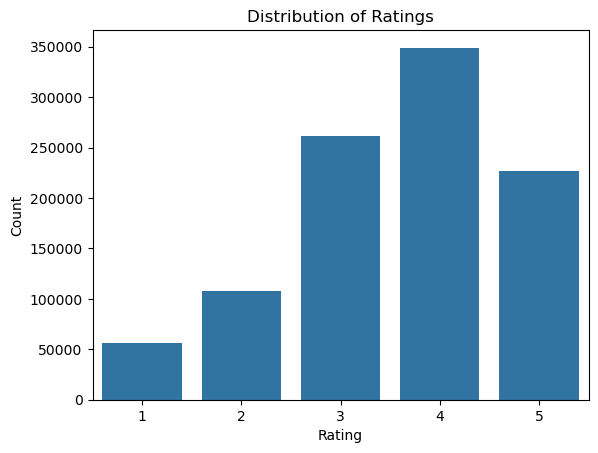

In [24]:
# Plot rating distribution
sns.countplot(data=ratings, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

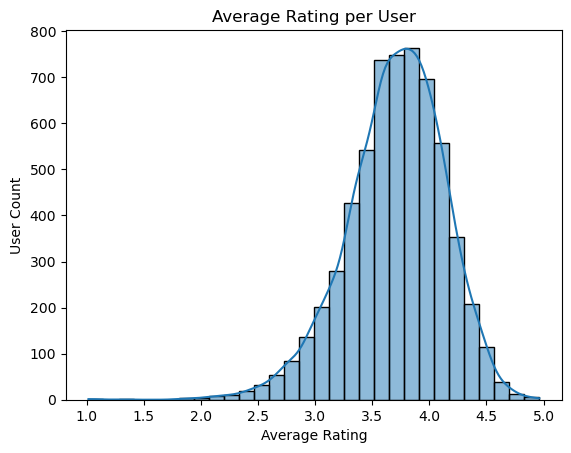

In [25]:
# Calculate average rating per user
user_avg = ratings.groupby('user_id')['rating'].mean()

# Plot distribution of user average ratings
sns.histplot(user_avg, bins=30, kde=True)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('User Count')
plt.show()

In [26]:
ratings.groupby('time_bucket')['rating'].mean().sort_values(ascending=False)

time_bucket
afternoon    3.604108
evening      3.596409
night        3.572660
morning      3.560403
Name: rating, dtype: float64

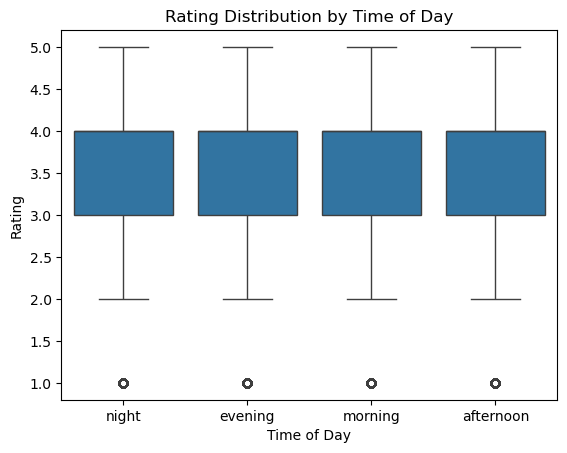

In [27]:
# Plot average rating by time bucket
sns.boxplot(data=ratings, x='time_bucket', y='rating')
plt.title('Rating Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Rating')
plt.show()

#### The differences are small
### Recommendation:
Use time_bucket as:
An input feature to modulate content type preferences.
A reweighting layer in hybrid models (e.g., recommend lighter content in morning, thrillers at night).

In [28]:
# Count how many ratings each user gave
ratings_per_user = ratings['user_id'].value_counts().sort_values(ascending=False)

# Basic stats
print("Summary stats of rating counts per user:")
print(ratings_per_user.describe())

Summary stats of rating counts per user:
count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: count, dtype: float64


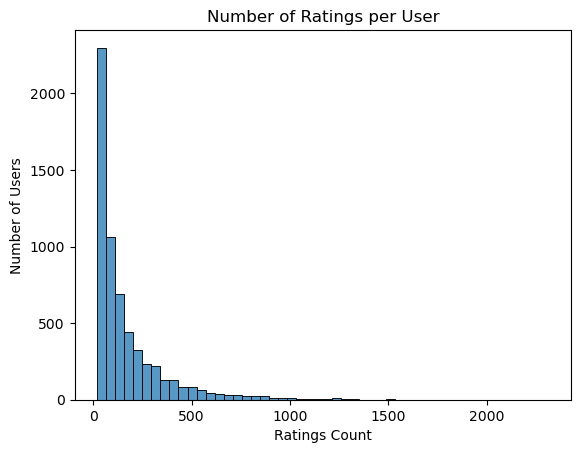

In [29]:
sns.histplot(ratings_per_user, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Ratings Count')
plt.ylabel('Number of Users')
plt.show()

In [30]:
ratings_per_user.head()

user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64

In [31]:
# Count cold-start users
num_cold_start_users = (ratings_per_user <= 20).sum()
total_users = ratings_per_user.shape[0]

print(f"Cold-start users (20 ratings): {num_cold_start_users}")
print(f"Total users: {total_users}")
print(f"Percentage of cold-start users: {100 * num_cold_start_users / total_users:.2f}%")

Cold-start users (20 ratings): 86
Total users: 6040
Percentage of cold-start users: 1.42%


### The dataset has a relatively strong base of active users, with most contributing well above 20 ratings.
Cold-start users: may use content-based models.

### Movie/Genre Patterns
- What are the most frequent genres overall?
- Which genres have the highest/lowest average ratings?
- What portion of movies belong to multiple genres?
- How many movies have fewer than 10 ratings (i.e., cold-start items)?

In [32]:
# Sum genre one-hot columns to count movie frequency per genre
genre_freq = movies[genre_codes.columns].sum().sort_values(ascending=False)

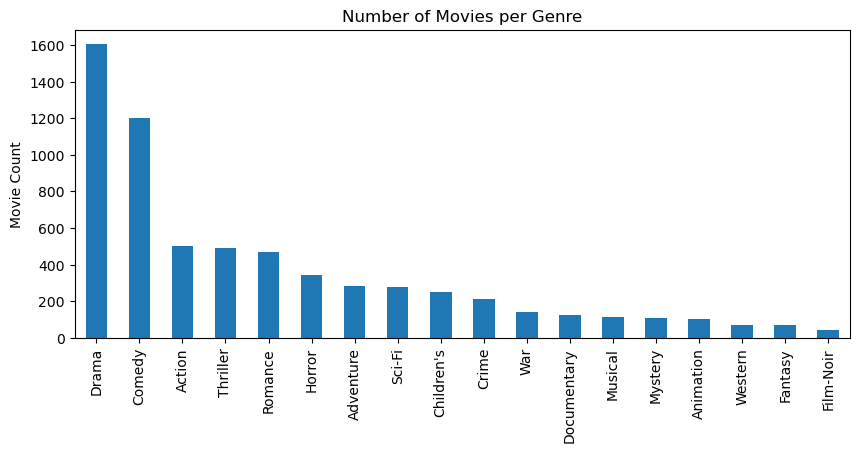

In [33]:
# Plot
genre_freq.plot(kind='bar', title='Number of Movies per Genre', figsize=(10,4))
plt.ylabel("Movie Count")
plt.show()

### Most common genres:
- Drama (appr 1,600 movies)
- Comedy (appr 1,200 movies)

### Rare genres:
- Fantasy, Western, Film-Noir: fewer than 100 movies

In [34]:
# Merge ratings and movies
ratings_with_genre = ratings.merge(movies[['movie_id'] + genre_codes.columns.tolist()], on='movie_id')

# Calculate mean rating per genre
genre_avg_ratings = {}
for genre in genre_codes.columns:
    genre_avg_ratings[genre] = ratings_with_genre[ratings_with_genre[genre] == 1]['rating'].mean()

# Convert to series and sort
genre_avg_ratings = pd.Series(genre_avg_ratings).sort_values(ascending=False)

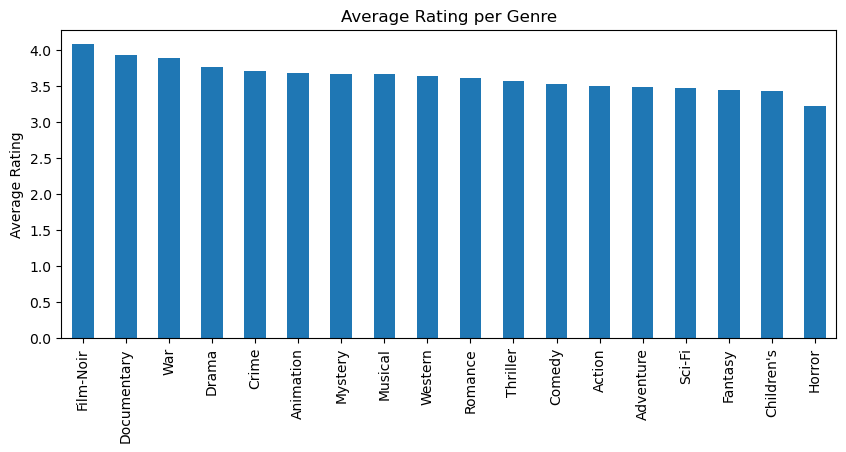

In [35]:
# Plot
genre_avg_ratings.plot(kind='bar', title='Average Rating per Genre', figsize=(10,4))
plt.ylabel("Average Rating")
plt.show()

#### Users show a clear preference for serious or artistic genres like Film-Noir and Documentaries.

#### Horror tends to receive lower ratings
- This can guide genre-aware weighting in content-based recommendations.

In [36]:
# Count how many genres each movie has
movies['genre_count'] = movies[genre_codes.columns].sum(axis=1)

# Calculate percentage with multiple genres
multi_genre_pct = (movies['genre_count'] > 1).mean() * 100
print(f"Percentage of movies with multiple genres: {multi_genre_pct:.2f}%")

Percentage of movies with multiple genres: 47.85%


- Nearly half the dataset consists of hybrid-genre films
- Useful for content-based filtering — shared genres can improve similarity measures between movies.

In [37]:
# Count ratings per movie
ratings_per_movie = ratings['movie_id'].value_counts()

# Cold-start: movies with < 10 ratings
cold_start_movies = (ratings_per_movie < 10).sum()
total_movies = ratings['movie_id'].nunique()

print(f"Cold-start movies (<10 ratings): {cold_start_movies}")
print(f"Total movies: {total_movies}")
print(f"Percentage of cold-start movies: {100 * cold_start_movies / total_movies:.2f}%")

Cold-start movies (<10 ratings): 446
Total movies: 3706
Percentage of cold-start movies: 12.03%


### over 1 in 10 movies lack enough interaction data
may handle them using:
- Content features (metadata, embeddings)
- Session-aware fallback rules

### Cold Start Detection
- Are certain genres or years overrepresented in cold-start movies?
- Do movies with very few ratings still follow genre popularity patterns?

In [38]:
# Identify cold-start movie IDs (< 10 ratings)
cold_start_ids = ratings_per_movie[ratings_per_movie < 10].index

# Create cold-start and non-cold-start subsets
cold_movies = movies[movies['movie_id'].isin(cold_start_ids)]
non_cold_movies = movies[~movies['movie_id'].isin(cold_start_ids)]

In [39]:
# Calculate genre proportions
cold_genre_dist = cold_movies[genre_codes.columns].sum() / len(cold_movies)
overall_genre_dist = movies[genre_codes.columns].sum() / len(movies)

# Compare distributions
genre_compare = pd.DataFrame({
    'Cold Start %': (cold_genre_dist * 100).round(2),
    'Overall %': (overall_genre_dist * 100).round(2)
})
display(genre_compare.sort_values('Cold Start %', ascending=False))

,Cold Start %,Overall %
Drama,52.91,41.28
Comedy,24.44,30.90
Documentary,8.74,3.27
Thriller,7.17,12.67
Romance,6.50,12.13
Horror,6.28,8.83
Action,5.61,12.95
Adventure,3.14,7.29
Crime,2.91,5.43
Sci-Fi,2.24,7.11


- Drama and Documentary dominate among cold-starts

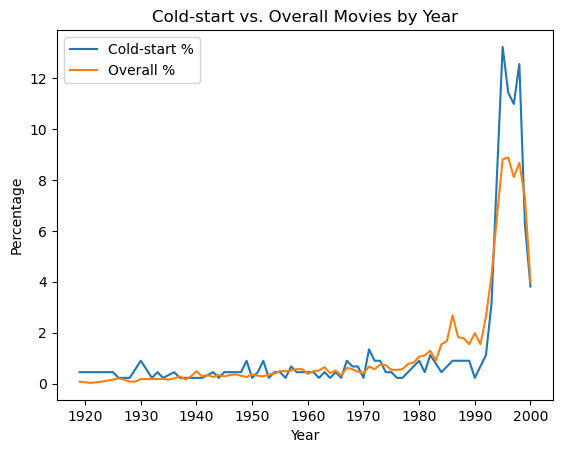

In [40]:
# Distribution of years
cold_year_dist = cold_movies['year'].value_counts().sort_index()
overall_year_dist = movies['year'].value_counts().sort_index()

# Normalize and plot
((cold_year_dist / cold_year_dist.sum()) * 100).plot(label='Cold-start %')
((overall_year_dist / overall_year_dist.sum()) * 100).plot(label='Overall %')
plt.title('Cold-start vs. Overall Movies by Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()
plt.show()

### Session/Time-of-Day Behavior
- What are the most active times of day for rating (hour buckets)?
- Does genre preference vary by time bucket (e.g., thrillers at night)?

In [41]:
ratings['time_bucket'].value_counts(normalize=True).sort_values(ascending=False)

time_bucket
night        0.503150
evening      0.231565
afternoon    0.152310
morning      0.112975
Name: proportion, dtype: float64

Nighttime dominates user engagement, with over 50% of all ratings.

In [42]:
# Count ratings per genre per time bucket
genre_time_counts = ratings_with_genre.groupby('time_bucket')[genre_codes.columns].sum()

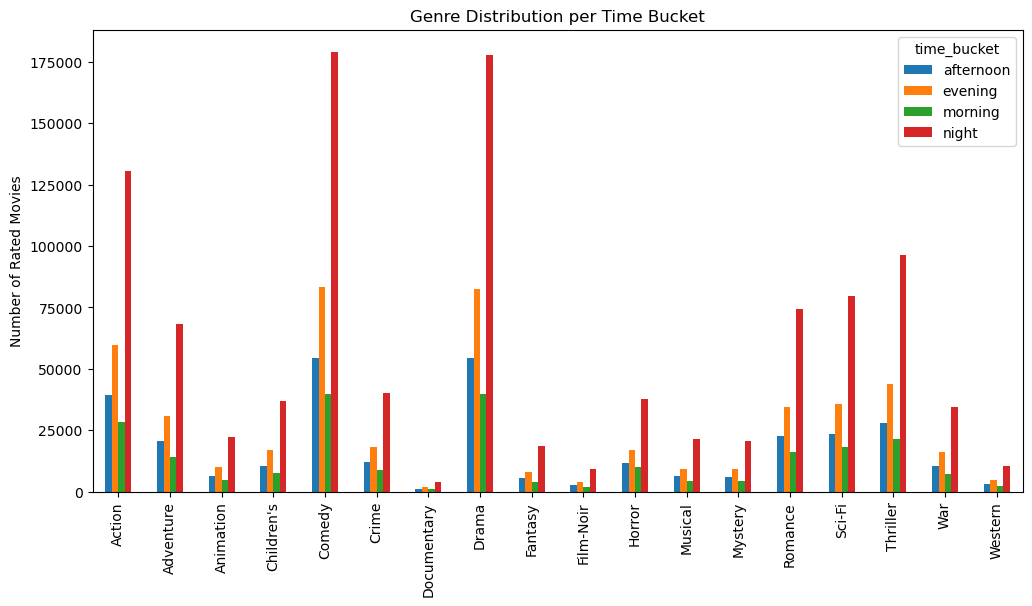

In [43]:
# Plot
genre_time_counts.T.plot(kind='bar', figsize=(12, 6), title='Genre Distribution per Time Bucket')
plt.ylabel('Number of Rated Movies')
plt.show()

No significant genre-specific peaks detected by time.

### User Engagement
- How does engagement vary across demographics (age, gender)?

In [44]:
# Merge ratings with user info
users.rename(columns={'userID': 'user_id'}, inplace=True)
ratings_users = ratings.merge(users, on='user_id')

In [45]:
ratings_users.groupby('gender')['user_id'].count()

gender
F    246440
M    753769
Name: user_id, dtype: int64

In [46]:
ratings_users.groupby('age')['user_id'].count().sort_values(ascending=False)

age
25    395556
35    199003
18    183536
45     83633
50     72490
56     38780
1      27211
Name: user_id, dtype: int64

### Male users contribute 3× more ratings than female users
### Younger adults (18–44) dominate engagement

#### Other Targeted EDA questions: 

- Which genres do different age groups prefer? 



In [ ]:
def analyze_genre_preferences_by_age():
    """
    Do different age groups prefer different movie genres?
    Target marketing campaigns by age demographics
    """
    
    
    merged_data = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
    
    # Create age groups
    merged_data['age_group'] = pd.cut(merged_data['age'], 
                                     bins=[0, 18, 25, 35, 45, 55, 100], 
                                     labels=['Under 18', '18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Split genres and create genre preferences by age
    genre_age_data = []
    for _, row in merged_data.iterrows():
        genres = row['genres'].split('|')
        for genre in genres:
            genre_age_data.append({
                'age_group': row['age_group'],
                'genre': genre,
                'rating': row['rating']
            })
    
    genre_age_df = pd.DataFrame(genre_age_data)
    
    # average rating and count by age group and genre
    genre_age_summary = genre_age_df.groupby(['age_group', 'genre']).agg({
        'rating': ['mean', 'count']
    }).round(2)
    
    # Top 3 genres for each age group 
    top_genres_by_age = genre_age_df.groupby(['age_group', 'genre'])['rating'].mean().reset_index()
    top_genres_by_age = top_genres_by_age.sort_values(['age_group', 'rating'], ascending=[True, False])
    result = top_genres_by_age.groupby('age_group').head(3)
    
    return result

analyze_genre_preferences_by_age()

,age_group,genre,rating
9,18-25,Film-Noir,4.058725
6,18-25,Documentary,3.946690
16,18-25,War,3.841240
27,26-35,Film-Noir,4.064910
24,26-35,Documentary,3.953747
34,26-35,War,3.901130
45,36-45,Film-Noir,4.105376
42,36-45,Documentary,3.966521
52,36-45,War,3.960554
63,46-55,Film-Noir,4.175401


- Which movies are the most polarizing? Which movies are likely to hit home everytime? 

In [ ]:
def find_controversial_movies():
    """
    Which movies divide audiences the most?
    Identify polarizing content for targeted marketing, consistent content for safe recommendations. 
    """
    
    # Calculate rating statistics per movie
    movie_stats = ratings.groupby('movie_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
    movie_stats = movie_stats.merge(movies, on='movie_id')
    
    # Filter movies with at least 50 ratings for statistical significance
    popular_movies = movie_stats[movie_stats['count'] >= 50]
    
    # Most controversial (highest standard deviation)
    most_controversial = popular_movies.nlargest(10, 'std')[['title', 'mean', 'std', 'count']]
    
    # Most consistent (lowest standard deviation)
    most_consistent = popular_movies.nsmallest(10, 'std')[['title', 'mean', 'std', 'count']]
    
    print("Most Controversial Movies (High Rating Variance):")
    print(most_controversial)
    print("\nMost Consistently Rated Movies:")
    print(most_consistent)

    
    
    return most_controversial, most_consistent

find_controversial_movies()

Most Controversial Movies (High Rating Variance):
                                               title      mean       std  \
1149                                Braindead (1992)  3.357143  1.464910   
1744                  Plan 9 from Outer Space (1958)  2.634538  1.455998   
2313                   Breakfast of Champions (1999)  2.981481  1.407403   
2083                       Six-String Samurai (1998)  3.366197  1.406510   
2169                           Glen or Glenda (1953)  2.849057  1.392234   
3476                            American Pimp (1999)  3.311475  1.372844   
2122                                  Beloved (1998)  3.134615  1.372813   
3618  Godzilla 2000 (Gojira ni-sen mireniamu) (1999)  2.692308  1.364700   
3113                     Bride of the Monster (1956)  2.802817  1.358778   
2266             Texas Chainsaw Massacre, The (1974)  3.222672  1.332448   

      count  
1149     70  
1744    249  
2313     54  
2083     71  
2169     53  
3476     61  
2122    104  
3

(                                               title      mean       std  \
 1149                                Braindead (1992)  3.357143  1.464910   
 1744                  Plan 9 from Outer Space (1958)  2.634538  1.455998   
 2313                   Breakfast of Champions (1999)  2.981481  1.407403   
 2083                       Six-String Samurai (1998)  3.366197  1.406510   
 2169                           Glen or Glenda (1953)  2.849057  1.392234   
 3476                            American Pimp (1999)  3.311475  1.372844   
 2122                                  Beloved (1998)  3.134615  1.372813   
 3618  Godzilla 2000 (Gojira ni-sen mireniamu) (1999)  2.692308  1.364700   
 3113                     Bride of the Monster (1956)  2.802817  1.358778   
 2266             Texas Chainsaw Massacre, The (1974)  3.222672  1.332448   
 
       count  
 1149     70  
 1744    249  
 2313     54  
 2083     71  
 2169     53  
 3476     61  
 2122    104  
 3618    143  
 3113     71  
 

- What genres perform the best over time (having trouble with this) 

- Which users give the highest quality and consistent feedback? 

In [ ]:
def identify_valuable_user_segments():
    """
    Which users provide the most ratings and highest quality feedback?
    Focus retention efforts on high-value users
    """
    
    merged_data = ratings.merge(users, on='user_id')
    
    # User activity analysis
    user_activity = merged_data.groupby('user_id').agg({
        'rating': ['count', 'mean', 'std'],
        'age': 'first',
        'gender': 'first',
        'occupation': 'first'
    }).round(2)
    
    user_activity.columns = ['rating_count', 'avg_rating', 'rating_std', 'age', 'gender', 'occupation']
    user_activity = user_activity.reset_index()
    
    # Identify power users (top 10% by rating count)
    power_user_threshold = user_activity['rating_count'].quantile(0.9)
    power_users = user_activity[user_activity['rating_count'] >= power_user_threshold]
    
    # Power user demographics
    power_user_demographics = power_users.groupby(['gender', 'occupation']).size().reset_index(name='count')
    power_user_demographics = power_user_demographics.sort_values('count', ascending=False)
    
    print("Top User Segments (Power Users):")
    print(power_user_demographics.head(10))
    
    return power_users, power_user_demographics

identify_valuable_user_segments()

Top User Segments (Power Users):
   gender  occupation  count
19      M           0     77
23      M           4     60
26      M           7     55
35      M          16     33
39      M          20     32
36      M          17     32
20      M           1     29
21      M           2     25
31      M          12     23
33      M          14     22


(      user_id  rating_count  avg_rating  rating_std  age gender  occupation
 9          10           401        4.11        0.84   35      F           1
 25         26           400        2.96        1.03   25      M           7
 47         48           598        3.07        0.82   25      M           4
 52         53           684        4.24        0.95   25      M           0
 57         58           437        3.97        0.99   25      M           2
 ...       ...           ...         ...         ...  ...    ...         ...
 5971     5972           437        3.71        0.90   25      F          20
 5995     5996           591        3.81        0.96   25      F           0
 5999     6000           506        3.25        0.91   45      M          17
 6015     6016           909        3.19        0.93   45      M           1
 6035     6036           888        3.30        1.02   25      F          15
 
 [605 rows x 7 columns],
    gender  occupation  count
 19      M         